In [1]:
import tensorflow as tf

2025-10-13 18:24:22.959901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760379863.143024      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760379863.197820      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
# from keras_flops import get_flops


IMG_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [33]:
base_model = Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Compiling model...


In [5]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 23,661,395
Trainable parameters: 23,603,283


In [ ]:
checkpoint_cb = ModelCheckpoint(
    "best_Xception_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print("Xception Starting training ")
!curl -d "Train Start" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")
!curl -d "Xception Train Complete" ntfy.sh/model_complete

with open('training_history.json', 'w') as f:
    json.dump(history.history,f)

Xception Starting training 
{"id":"JMHrhEjsGo5N","time":1760377320,"expires":1760420520,"event":"message","topic":"model_complete","message":"Train Start"}
Epoch 1/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1881 - loss: 2.9595
Epoch 1: val_accuracy improved from -inf to 0.42501, saving model to best_Xception_model.h5


In [7]:
# Load the best model
model = tf.keras.models.load_model("best_Xception_model.h5")
with open("training_history.json") as file:
    history = json.load(file)

374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step
Test Loss: 0.6290
Test Accuracy: 0.7787
Precision: 0.7789
Recall: 0.7724
F1 Score: 0.7591
Parameters: 23661395


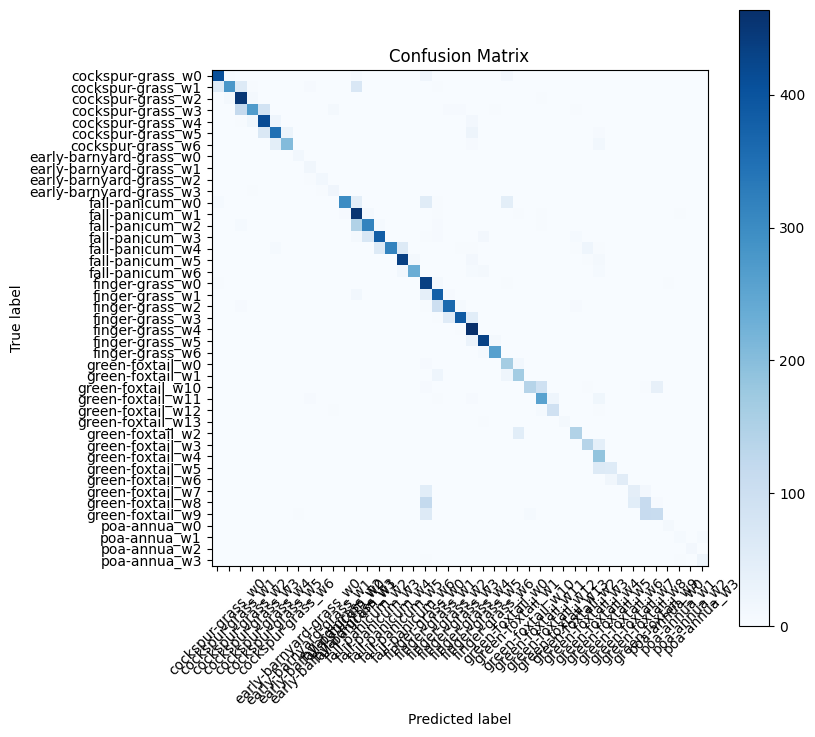

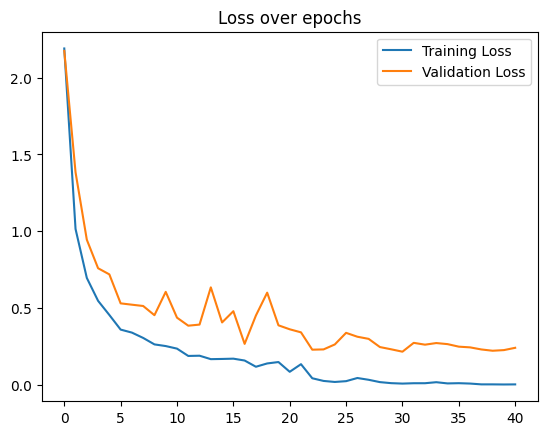

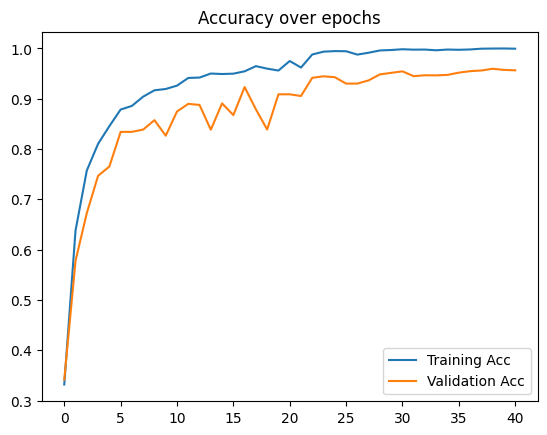

In [9]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history["accuracy"], label="Training Acc")
plt.plot(history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()

In [ ]:
model.save('xception_final_model.keras')
model.save_weights('xception_final.weights.h5')

| Model    |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:---------|---------:|------------:|-----------:|------------:|---------:|-------:|
| Xception | 23661395 |       0.629 |     0.7787 |      0.7789 |   0.7724 | 0.7591 |


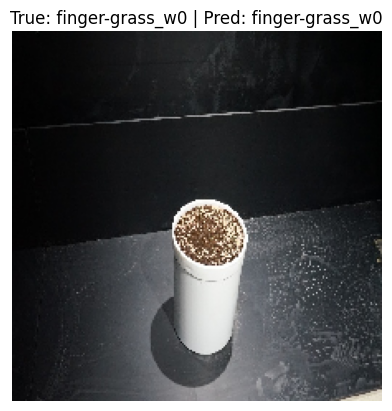

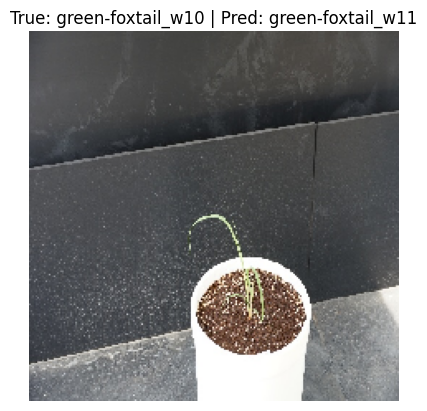

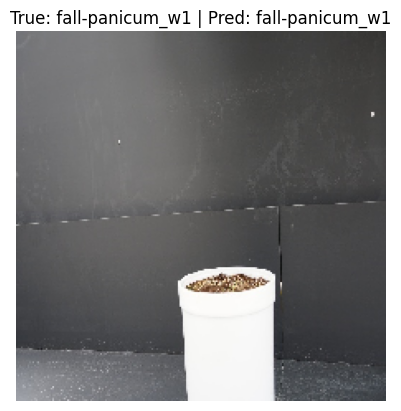

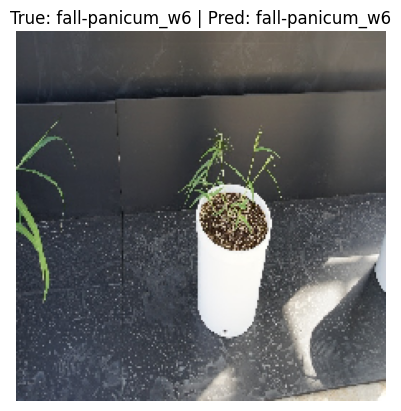

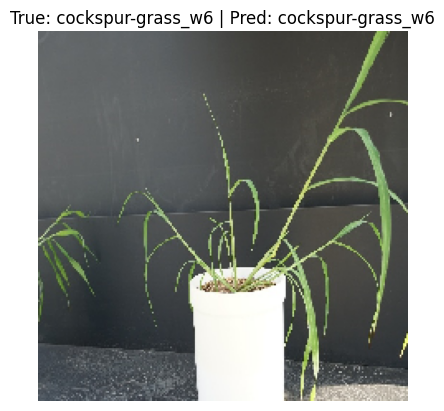

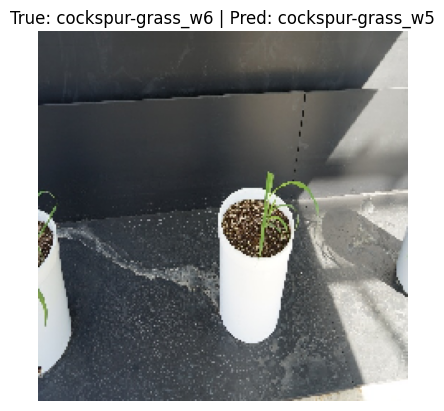

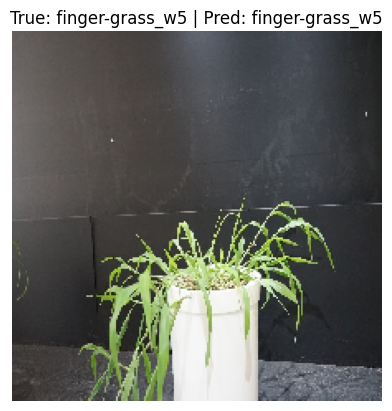

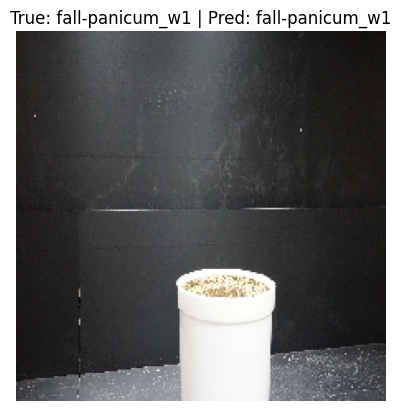

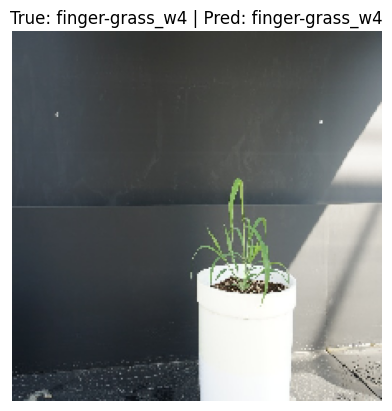

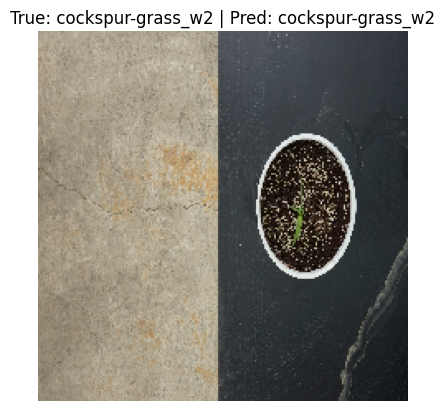

{"id":"Uj872pCg4D3Y","time":1760380486,"expires":1760423686,"event":"message","topic":"model_complete","message":"Finished"}


In [11]:
import pandas as pd
results = {
    "Model": ["Xception"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "Finished" ntfy.sh/model_complete